In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/._chest_xray
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/._test
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/._train
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/._.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/._.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA/._person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA/._person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA/._person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA/._person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA/._person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray

In [2]:
#imports
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from keras.callbacks import ReduceLROnPlateau

Looking at some images

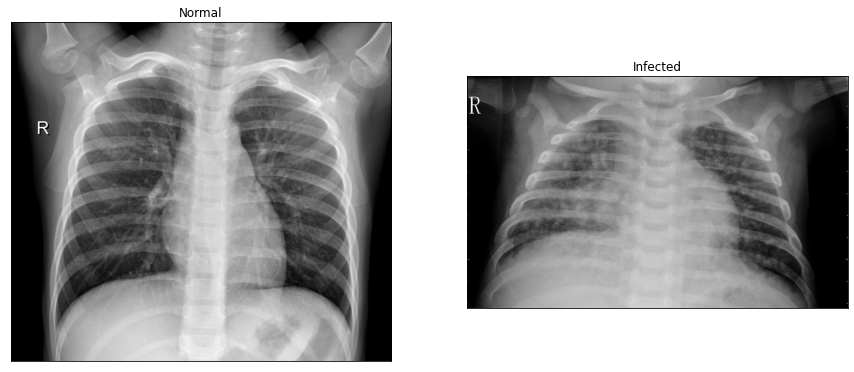

In [3]:
n = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0578-0001.jpeg'
p = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1643_bacteria_4354.jpeg'
plt.figure(1,figsize=(15,7))

plt.subplot(1,2,1)
plt.imshow(cv2.imread(n))
plt.title('Normal')
plt.xticks([]) , plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(cv2.imread(p))
plt.title('Infected')
plt.xticks([]) , plt.yticks([])

plt.show()

# Loading the data

In [4]:
datagen = ImageDataGenerator(rescale=1./255,
                            #zoom_range = 0.2, # Randomly zoom image 
                                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                                horizontal_flip=True,
                             shear_range = 0.2
                            )
valgen = ImageDataGenerator(rescale = 1./255)

train_data = datagen.flow_from_directory('/kaggle/input/chest-xray-pneumonia/chest_xray/train/',
                                         target_size=(250,250),
                                         batch_size=128,
                                         class_mode = 'binary',
                                         color_mode = 'grayscale',
                                         )

test_data = valgen.flow_from_directory('/kaggle/input/chest-xray-pneumonia/chest_xray/test/',
                                         target_size=(250,250),
                                         batch_size=128,
                                         class_mode = 'binary',
                                        color_mode = 'grayscale',
                                         )

val_data = valgen.flow_from_directory('/kaggle/input/chest-xray-pneumonia/chest_xray/val/',
                                         target_size=(250,250),
                                         batch_size=128,
                                         class_mode = 'binary',
                                       color_mode = 'grayscale',
                                         )

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [5]:
image_batch = train_data[0][0]

#plt.figure(figsize=(20,5))
#for i in range(len(image_batch)):
#    plt.subplot(2,8,i+1)
#    pil_img = array_to_img(image_batch[i])
#    plt.imshow(pil_img,cmap='gray')
#    plt.axis('off')
#plt.tight_layout()
#plt.show()

# Modelling

In [6]:
model = Sequential([
    
    # Block One
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(250,250,1)),
    MaxPool2D((2,2)),
    Conv2D(filters=32, kernel_size=3, activation='relu',padding='same'),
    MaxPool2D((2,2)),

    # Block Two
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(filters=64, kernel_size=3, activation='relu',padding='same'),
    MaxPool2D((2,2)),
    Dropout(0.2),
    Conv2D(filters=64, kernel_size=3, activation='relu',padding='same'),
    MaxPool2D((2,2)),
    

    # Head
    Flatten(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid'),
])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        1

In [7]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Training

In [8]:
history = model.fit_generator(generator = train_data,
                             steps_per_epoch = len(train_data),
                              epochs = 20,
                              validation_data = val_data,
                              validation_steps=len(val_data),
                             callbacks=early_stopping)

Epoch 1/20
41/41 [==============================] - 83s 2s/step - loss: 0.8507 - accuracy: 0.7061 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/20
41/41 [==============================] - 69s 2s/step - loss: 0.6814 - accuracy: 0.7429 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 3/20
41/41 [==============================] - 69s 2s/step - loss: 0.4902 - accuracy: 0.7968 - val_loss: 0.6447 - val_accuracy: 0.6250
Epoch 4/20
41/41 [==============================] - 68s 2s/step - loss: 0.2374 - accuracy: 0.9051 - val_loss: 0.6394 - val_accuracy: 0.8750
Epoch 5/20
41/41 [==============================] - 68s 2s/step - loss: 0.2069 - accuracy: 0.9185 - val_loss: 0.6304 - val_accuracy: 0.7500
Epoch 6/20
41/41 [==============================] - 68s 2s/step - loss: 0.1797 - accuracy: 0.9298 - val_loss: 0.6060 - val_accuracy: 0.8125
Epoch 7/20
41/41 [==============================] - 67s 2s/step - loss: 0.1486 - accuracy: 0.9406 - val_loss: 0.5934 - val_accuracy: 0.8750
Epoch 8/20
41/41 [==

In [9]:
print("Loss of the model is - " , model.evaluate(test_data)[0])
print("Accuracy of the model is - " , model.evaluate(test_data)[1]*100 ,"%")

5/5 [==============================] - 5s 1s/step - loss: 0.4712 - accuracy: 0.7949
Loss of the model is -  0.47115692496299744
5/5 [==============================] - 4s 702ms/step - loss: 0.4712 - accuracy: 0.7949
Accuracy of the model is -  79.48718070983887 %


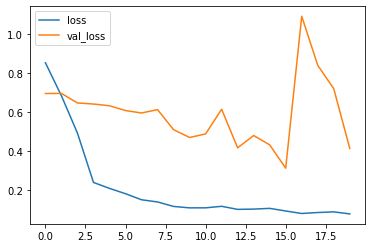

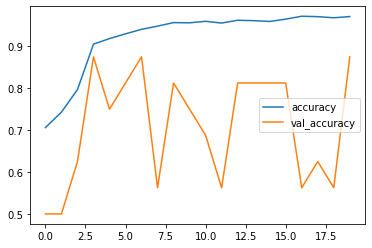

In [10]:
hist_df = pd.DataFrame(history.history)
hist_df.loc[:,['loss','val_loss']].plot()
hist_df.loc[:,['accuracy','val_accuracy']].plot()